In [ ]:
with open('docword.nips.txt') as f:
  text = list(map(int, f.read().replace('\n', ' ').split()))
  id_arr = text[3::3]
  word_arr = text[4::3]
  wc_arr = text[5::3]

Шаг 1. Соберем матрицу признаков (каждый признак - число вхождений конкретного слова в текст)

In [ ]:
import numpy as np

# obtaining unique identifiers
words = np.unique(word_arr)
ids = np.unique(id_arr)

# creating overall dataset
X = np.zeros((ids.shape[0], words.shape[0]))

for k in range(len(word_arr)):
  i = np.argwhere(ids == id_arr[k])[0]
  j = np.argwhere(words == word_arr[k])[0]

  X[i, j] = wc_arr[k]

del id_arr, word_arr, wc_arr, text

Шаг 2. Не хочется чтобы ответ зависел от размера текста поэтому переведем количество слов в их частоту

In [ ]:
# Step 0: convert counter to frequency of words (sort of scalling)

X_scaled = X / np.sum(X, axis=1)[:, None]

# Эвристический графовый алгоритм

В качестве Эвристического графого алгоритма будем использовать алгоритм выделения связанных компонент, т.к. алгоритмы выделения пути кажутся не очень логичным в нашей задаче. Здесь все-таки задача в том чтобы выделить максимально "похожие" друг друга на тексты. 

За метрику всюду будем расматривать Манхэтоновскую метрику

In [ ]:
def metrics(i, j):
  return np.sum(np.abs(X_scaled[i, :] - X_scaled[j, :]))

# affinity matrix

A = np.zeros((ids.shape[0], ids.shape[0]))

for i in range(ids.shape[0]):
  for j in range(i+1, ids.shape[0]):
    A[i, j] = metrics(i,j)

A += A.T

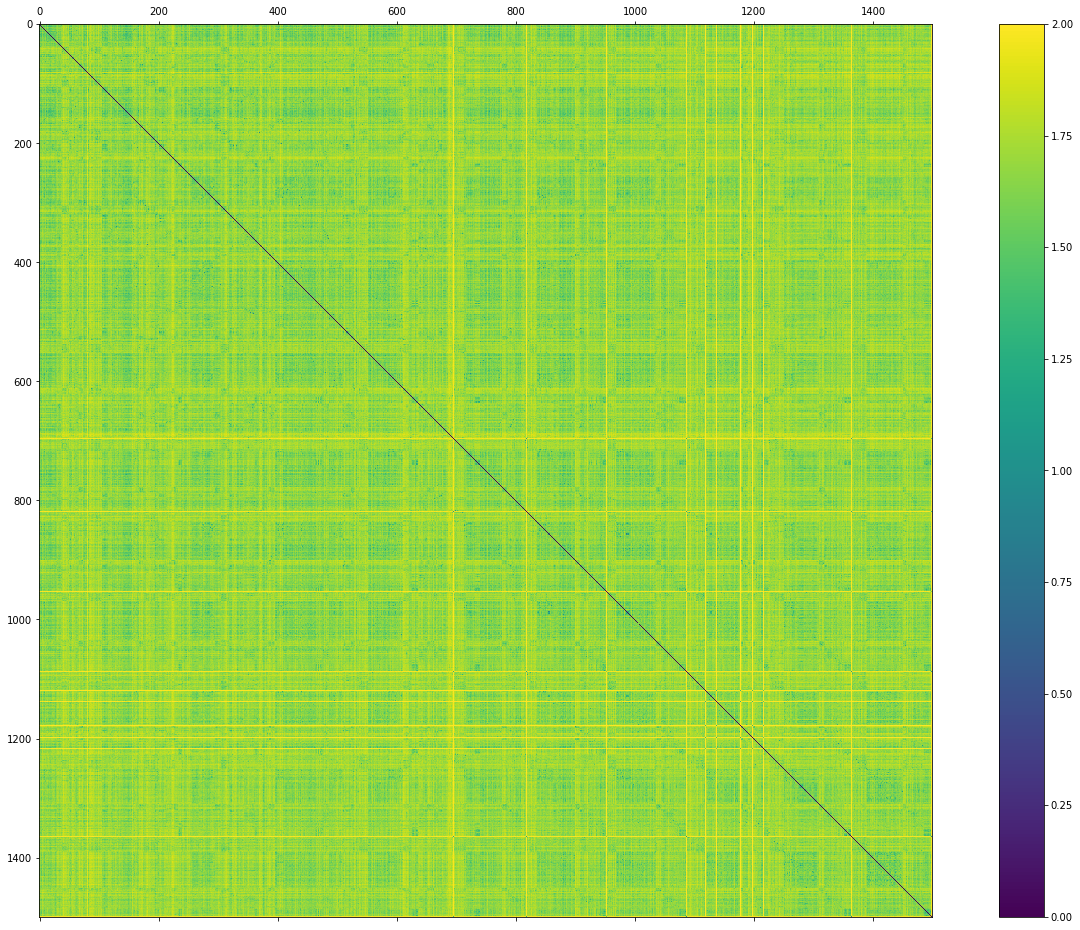

In [ ]:
import matplotlib.pyplot as plt
# visualization of affinity matrix
plt.figure(figsize = (24, 16))
plt.matshow(A, fignum=1)
plt.colorbar()
plt.show()

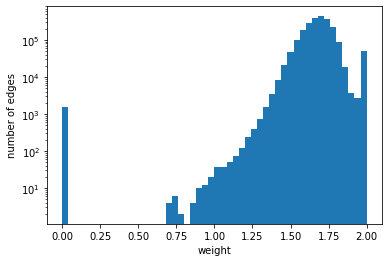

In [ ]:
# histogram \rho_ij

plt.hist(A.flatten(), bins = 50)
plt.yscale('log')
plt.xlabel('weight')
plt.ylabel('number of edges')
plt.show()

Какой вывод тут можно сделать

1. Ноль нужно игнорить, т.к. он взялся от диагональных элементов матрицы смежности
2. Локальный минмум в распредлении присутсвует где-то в районе $R = 0.8$ и его стоит взять за параметр разбиения на компоненты связаности


Но на деле мне больше понравился результат для $R = 1.2$ (судил по гистограмме ниже, а перебирал почти все что мог по параметру)

In [ ]:
import copy

R = 1.25

clusters = {}
cluster_id = 1

ids_left = copy.copy((ids-1).tolist())

while(ids_left):
  # start a new cluster
  cur_id = ids_left.pop()
  to_visit = [cur_id]

  clusters[cluster_id] = set()

  while(to_visit):
    cur_id = to_visit.pop()
    clusters[cluster_id].add(cur_id)

    tmp = []
    while(ids_left):
      el = ids_left.pop()
      if A[cur_id, el] <= R:
        to_visit.append(el)
      else:
        tmp.append(el)
    ids_left = copy.copy(tmp)

  cluster_id += 1 

number of clusters: 1200


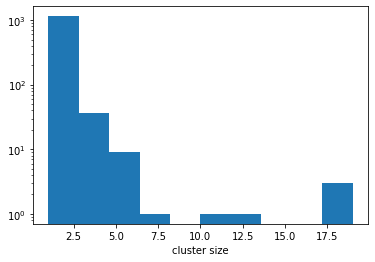

mean cluster size : 1.25
dispertion of cluster size : 1.16081867662439


In [ ]:
print('number of clusters:', len(list(clusters.keys())))
cl_len = list(map(len, clusters.values()))

plt.hist(cl_len)
plt.xlabel('cluster size')
plt.yscale('log')
plt.show()

print('mean cluster size :', np.mean(cl_len))
print('dispertion of cluster size :', np.std(cl_len))

Вывод: кластеризация получилась откровенно стремная. Видим большое число кластеров из которых не так много из них имеют размер больше единицы (изолированные точки).

### Статический метод кластеризации



За статистический алгоритм кластеризации рассмотрим k-means. На самом деле я его решил исопльзовать из-за простой имплементации из коробки и по той простой причине, что он относительно прост и является наверное самым популярным алгоритмом кластеризации.

Однако большой вопрос здесь в числе кластеров, которое на самом деле подбиралось руками и ориенитровался я здесь только на переупорядоченную мтарицу смежности (плот которой будет чуть позже)

In [ ]:
from sklearn.cluster import KMeans

N_c = 8
kmeans = KMeans(n_clusters=N_c,)
kmeans.fit(X_scaled)

KMeans()

In [ ]:
# visualize the result with reordering of affinity matrix

labels = kmeans.labels_

A_new = np.copy(A)

filt = []

for i in range(N_c):
  filt += np.argwhere(labels == i)[:, 0].tolist()

A_new = A[:, filt][filt, :]

Для визуализации кластеризации возьмем матрицу смежности из предыдущего пункта и переномируем её в порядке вхождения в кластер (т.е. сперва только объекты перовго класетра, потом второго и т.д.)

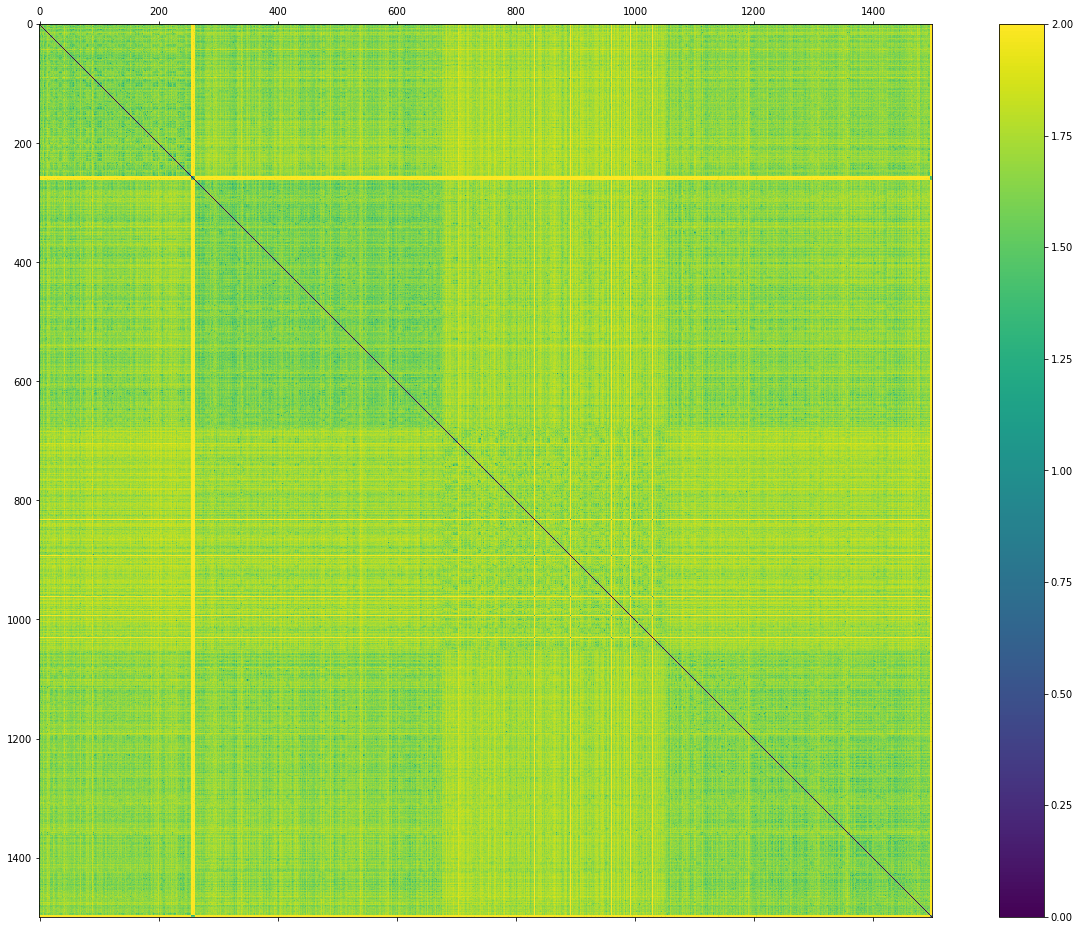

In [ ]:
import matplotlib.pyplot as plt
# visualization of reordered affinity matrix
plt.figure(figsize = (24, 16))
plt.matshow(A_new, fignum=1)
plt.colorbar()
plt.show()

In [ ]:
print('number of clusters :', len(np.unique(labels)))

for i in range(len(np.unique(labels))):
  print('cluster {} size :'.format(i+1), np.sum(labels==i))

number of clusters : 8
cluster 1 size : 256
cluster 2 size : 2
cluster 3 size : 4
cluster 4 size : 416
cluster 5 size : 379
cluster 6 size : 440
cluster 7 size : 1
cluster 8 size : 2


Ну в целом, виузально уже хорошо отделяются кластеры (т.е. можно расмотреть диагональные блоки - кластеры, в рамках которых попарные растояния достаточно малы)

# Алгоритм иерархичесской кластеризации

In [ ]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(affinity='manhattan', linkage='average', n_clusters=8).fit(X_scaled)
labels = clustering.labels_

In [ ]:
# visualize the result with reordering of affinity matrix

A_new = np.copy(A)

filt = []

for i in range(clustering.n_clusters_):
  filt += np.argwhere(labels == i)[:, 0].tolist()

A_new = A[:, filt][filt, :]

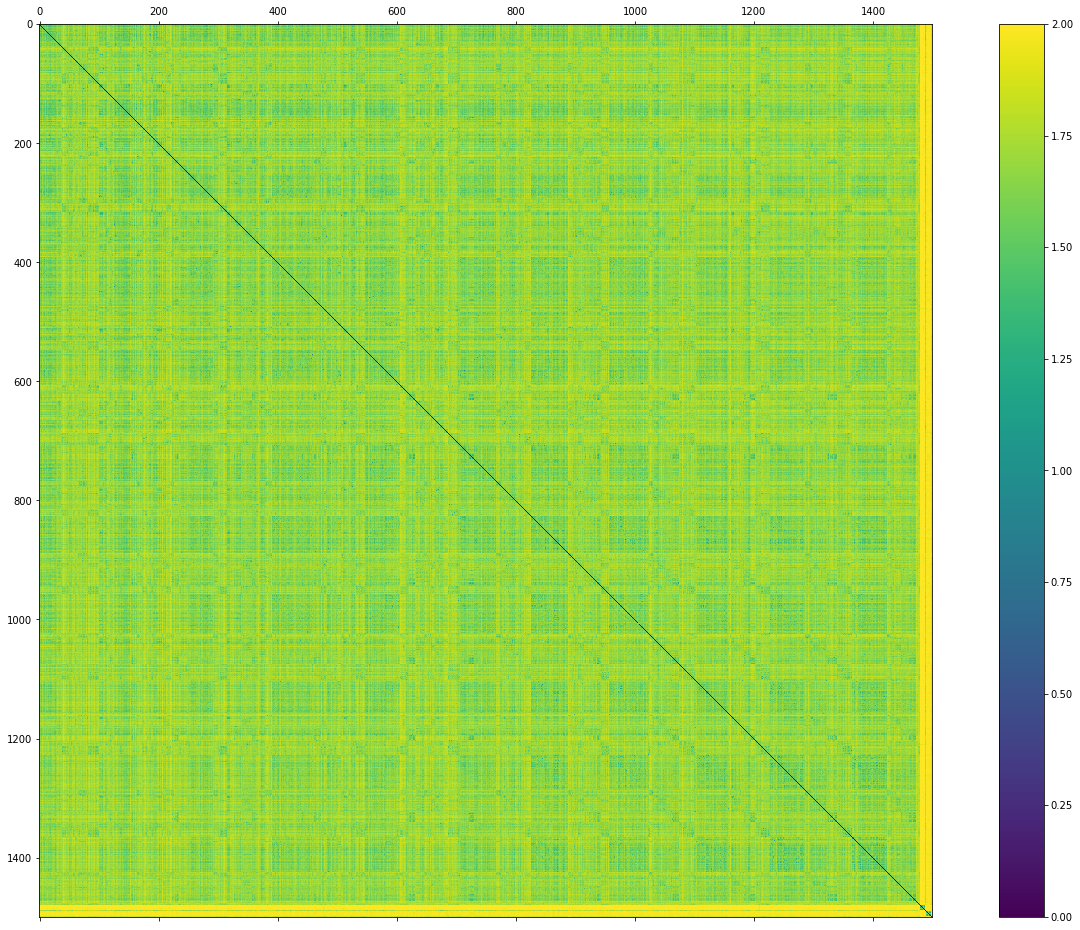

In [ ]:
import matplotlib.pyplot as plt
# visualization of reordered affinity matrix
plt.figure(figsize = (24, 16))
plt.matshow(A_new, fignum=1)
plt.colorbar()
plt.show()

In [ ]:
print('number of clusters :', len(np.unique(labels)))

for i in range(len(np.unique(labels))):
  print('cluster {} size :'.format(i+1), np.sum(labels==i))

number of clusters : 8
cluster 1 size : 1473
cluster 2 size : 3
cluster 3 size : 2
cluster 4 size : 2
cluster 5 size : 9
cluster 6 size : 1
cluster 7 size : 9
cluster 8 size : 1


Получилось немного плохо, вероятно из-за того что выбранная метрика, среднее растояние между кластерами, слишком схожа на начальных иттерациях и из-за этого почти все объекты собрались в один большой кластер